In [1]:
def run_esn_quantization(N, bit_width):
    from reservoirpy.datasets import narma
    from reservoirpy.nodes import Reservoir, Ridge
    from reservoirpy.observables import rmse, rsquare, nrmse
    from brevitas.nn import QuantIdentity
    import numpy as np
    import torch
    from reservoirpy import Node
    # rpy.verbosity(0)  # no need to be too verbose here
    # rpy.set_seed(42)  # make everything reproducible!
    # Prepare Lorenz dataset
    # X = narma(10000)
    # X = 2 * (X - X.min()) / (X.max() - X.min()) - 1
    n_timesteps, order = 10000, 10
    rng = np.random.default_rng(seed=2341)
    u = rng.uniform(0, 0.5, size=(n_timesteps + order, 1))
    X = narma(n_timesteps=n_timesteps, order=order, u=u)
    X_train = u[order:5000+order]
    y_train = X[1:5001]

    X_test= u[5001+order:-1]
    y_test = X[5002:]
    train_len = 5000
    threshold_scale = 1.0 / (2 ** bit_width) 

    # Initialize and train ESN (FP32)
    reservoir = Reservoir(N, lr=1, sr=0.76, input_connectivity=0.9, rc_connectivity=0.1, input_scaling=1)
    readout = Ridge(ridge=1e-10)
    esn_model = reservoir >> readout
    esn_model = esn_model.fit(X_train,y_train, warmup=1000)

    # Quantization helper
    def extract_Qinput(input_array, num_bits):
        quant_identity = QuantIdentity(return_quant_tensor=True, bit_width=num_bits)
        float_input = torch.tensor(input_array, dtype=torch.float64)
        quant_input = quant_identity(float_input)
        return (
            quant_input.int().detach().numpy(),
            quant_input.scale.detach().numpy(),
            quant_input.zero_point.detach().numpy()
        )

   # Extract quantized versions
    int_x, x_scale, _ = extract_Qinput(X, num_bits=bit_width)
    int_Win, scale_Win, _ = extract_Qinput(esn_model.nodes[0].Win.todense(), num_bits=bit_width)
    int_Wr, scale_Wr, _ = extract_Qinput(esn_model.nodes[0].W.todense(), num_bits=bit_width)
    int_bias, _, _ = extract_Qinput(esn_model.nodes[0].bias.todense(), num_bits=bit_width)

    input_scale = (scale_Win * x_scale)
    reservoir_scale = (scale_Wr * threshold_scale)

    def compute_integer_thresholds(scale):
        return np.int32(-1 / scale), np.int64(1 / scale)

    a_scaled, b_scaled = compute_integer_thresholds(input_scale)
    c_scaled, d_scaled = compute_integer_thresholds(reservoir_scale)

    def piecewise_linear_hard_tanh_integer(x, a_scaled, b_scaled, div_scale):
        x = np.clip(x, a_scaled, b_scaled)
        x = x + b_scaled
        return (x / div_scale).astype(np.int64)

    div_scale = 2 ** bit_width

    def forward2(node: Node, x: np.ndarray) -> np.ndarray:
        state = node.state().astype(np.int64).reshape(1, N)
        r = state @ node.Wr.astype(np.int64)
        s = x @ node.Win.astype(np.int64).T
        s = s.reshape(1, N)
        out_r = piecewise_linear_hard_tanh_integer(s, a_scaled, b_scaled, div_scale)
        out_s = piecewise_linear_hard_tanh_integer(r, c_scaled, d_scaled, div_scale)
        return out_r + out_s + node.Bias.reshape(1, N)

    def initialize(node: Node, x: np.ndarray = None, y: np.ndarray = None):
        if x is not None:
            node.set_input_dim(x.shape[1])
            node.set_output_dim(N)
            node.set_param("Wr", int_Wr)
            node.set_param("Win", int_Win)
            node.set_param("Bias", int_bias)

    class CustomNode(Node):
        def __init__(self, name=None):
            super().__init__(
                forward=forward2,
                initializer=initialize,
                params={"Wr": None, "Win": None, "Bias": None},
                hypers={},
                name=name
            )

    node = CustomNode(name=f"quant_reservoir_N{N}_b{bit_width}")
    esn_model_PTQ = node >> readout

    Quantized_States = node.run(int_x[:train_len].astype(np.float64)) * threshold_scale
    readout.fit(Quantized_States, X[1:train_len + 1], warmup=1000)

    Quantized_States_test = node.run(int_x[train_len+1:-1].astype(np.float64)) * threshold_scale
    Y_pred_PTQ = readout.run(Quantized_States_test)

    # Evaluation
    a="R\u00B2"

    Y_true = X[train_len + 2:]
    return {
        "N": N,
        "bits": bit_width,
        "RMSE": rmse(Y_true, Y_pred_PTQ),
        "NRMSE": nrmse(Y_true, Y_pred_PTQ),
        "R\u00B2": rsquare(Y_true, Y_pred_PTQ)
    }

 

In [2]:
def run_esn_float(N):
    from reservoirpy.datasets import narma
    from reservoirpy.nodes import Reservoir, Ridge
    from reservoirpy.observables import rmse, rsquare, nrmse
    import numpy as np
    # rpy.verbosity(0)  # no need to be too verbose here
    # rpy.set_seed(42)  # make everything reproducible!
    n_timesteps, order = 10000, 10
    rng = np.random.default_rng(seed=2341)
    u = rng.uniform(0, 0.5, size=(n_timesteps + order, 1))
    X = narma(n_timesteps=n_timesteps, order=order, u=u)
    X_train = u[order:5000+order]
    y_train = X[1:5001]

    X_test= u[5001+order:-1]
    y_test = X[5002:]
    train_len = 5000

    reservoir = Reservoir(N, lr=1, sr=0.76, input_connectivity=0.9, rc_connectivity=0.1, input_scaling=1)
    readout = Ridge(ridge=1e-10)
    esn_model = reservoir >> readout
    esn_model = esn_model.fit(X_train, y_train, warmup=1000)

    Y_pred = esn_model.run(X_test)
    Y_true = y_test

    return {
        "N": N,
        "bits": "FP",
        "RMSE": rmse(Y_true, Y_pred),
        "NRMSE": nrmse(Y_true, Y_pred),
        "R\u00B2": rsquare(Y_true, Y_pred)
    }


In [3]:
# Define parameter sets
N_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bit_width_list = [4, 6, 8,16]

results = []

# Step 1: Run float (baseline) for each N
for N in N_list:
    print(f"Running float (FP32) evaluation for N={N}...")
    float_result = run_esn_float(N)
    results.append(float_result)

# Step 2: Run quantized evaluations
for N in N_list:
    for bits in bit_width_list:
        print(f"Running quantized evaluation for N={N}, bit_width={bits}...")
        quant_result = run_esn_quantization(N, bits)
        results.append(quant_result)

# Step 3: Create DataFrame and save
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)

# Optional: Save to CSV
df_results.to_csv("quantized_and_float_esn_results.csv", index=False)


Running float (FP32) evaluation for N=50...


Running Model-0: 5000it [00:00, 18523.28it/s]?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-0...


Running Model-0: 4998it [00:00, 20053.52it/s]         


Running float (FP32) evaluation for N=100...


Running Model-1: 5000it [00:00, 18853.19it/s]?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Fitting node Ridge-1...


Running Model-1: 4998it [00:00, 18450.12it/s]         


Running float (FP32) evaluation for N=150...


Running Model-2: 5000it [00:00, 18366.09it/s]?, ?it/s]
Running Model-2: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Fitting node Ridge-2...


Running Model-2: 4998it [00:00, 17797.99it/s]         


Running float (FP32) evaluation for N=200...


Running Model-3: 5000it [00:00, 17362.53it/s]?, ?it/s]
Running Model-3: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-3...


Running Model-3: 4998it [00:00, 17775.31it/s]         


Running float (FP32) evaluation for N=250...


Running Model-4: 5000it [00:00, 16579.06it/s]?, ?it/s]
Running Model-4: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-4...


Running Model-4: 4998it [00:00, 16784.52it/s]         


Running float (FP32) evaluation for N=300...


Running Model-5: 5000it [00:00, 16410.03it/s]?, ?it/s]
Running Model-5: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-5...


Running Model-5: 4998it [00:00, 16444.51it/s]         


Running float (FP32) evaluation for N=350...


Running Model-6: 5000it [00:00, 15591.65it/s]?, ?it/s]
Running Model-6: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-6...


Running Model-6: 4998it [00:00, 15084.45it/s]         


Running float (FP32) evaluation for N=400...


Running Model-7: 5000it [00:00, 15685.79it/s]?, ?it/s]
Running Model-7: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-7...


Running Model-7: 4998it [00:00, 15262.92it/s]         


Running float (FP32) evaluation for N=450...


Running Model-8: 5000it [00:00, 15213.99it/s]?, ?it/s]
Running Model-8: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-8...


Running Model-8: 4998it [00:00, 15401.43it/s]         


Running float (FP32) evaluation for N=500...


Running Model-9: 5000it [00:00, 14834.43it/s]?, ?it/s]
Running Model-9: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Fitting node Ridge-9...


Running Model-9: 4998it [00:00, 14388.51it/s]         


Running quantized evaluation for N=50, bit_width=4...


Running Model-10: 5000it [00:00, 18545.72it/s]?, ?it/s]
Running Model-10: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
/home/atousa/.local/lib/python3.10/site-packages/torch/_tensor.py:1644: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1935.)
  return super().rename(names)


Fitting node Ridge-10...


Running Ridge-10: 100%|██████████| 4998/4998 [00:00<00:00, 140368.09it/s]


Running quantized evaluation for N=50, bit_width=6...


Running Model-12: 5000it [00:00, 18179.40it/s]?, ?it/s]
Running Model-12: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Fitting node Ridge-11...


Running quant_reservoir_N50_b6: 100%|██████████| 5000/5000 [00:00<00:00, 48789.70it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.03609e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-11: 100%|██████████| 4998/4998 [00:00<00:00, 145514.65it/s]


Running quantized evaluation for N=50, bit_width=8...


Running Model-14: 5000it [00:00, 18620.23it/s]?, ?it/s]
Running Model-14: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Fitting node Ridge-12...


Running Ridge-12: 100%|██████████| 4998/4998 [00:00<00:00, 140155.05it/s]


Running quantized evaluation for N=50, bit_width=16...


Running Model-16: 5000it [00:00, 17767.66it/s]?, ?it/s]
Running Model-16: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
/tmp/ipykernel_2534163/2909204132.py:53: RuntimeWarning: invalid value encountered in cast
  return np.int32(-1 / scale), np.int64(1 / scale)


Fitting node Ridge-13...


Running quant_reservoir_N50_b16: 100%|██████████| 5000/5000 [00:00<00:00, 52560.07it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.07173e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-13: 100%|██████████| 4998/4998 [00:00<00:00, 142572.39it/s]


Running quantized evaluation for N=100, bit_width=4...


Running Model-18: 5000it [00:00, 18609.06it/s]?, ?it/s]
Running Model-18: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Fitting node Ridge-14...


Running quant_reservoir_N100_b4: 100%|██████████| 5000/5000 [00:00<00:00, 41288.94it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.94385e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-14: 100%|██████████| 4998/4998 [00:00<00:00, 144336.41it/s]


Running quantized evaluation for N=100, bit_width=6...


Running Model-20: 5000it [00:00, 18621.24it/s]?, ?it/s]
Running Model-20: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Fitting node Ridge-15...


Running quant_reservoir_N100_b6: 100%|██████████| 5000/5000 [00:00<00:00, 41091.78it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.08729e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-15: 100%|██████████| 4998/4998 [00:00<00:00, 141097.46it/s]


Running quantized evaluation for N=100, bit_width=8...


Running Model-22: 5000it [00:00, 18102.90it/s]?, ?it/s]
Running Model-22: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Fitting node Ridge-16...


Running quant_reservoir_N100_b8: 100%|██████████| 5000/5000 [00:00<00:00, 43105.95it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.3293e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-16: 100%|██████████| 4998/4998 [00:00<00:00, 139125.36it/s]


Running quantized evaluation for N=100, bit_width=16...


Running Model-24: 5000it [00:00, 18722.05it/s]?, ?it/s]
Running Model-24: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Fitting node Ridge-17...


Running quant_reservoir_N100_b16: 100%|██████████| 5000/5000 [00:00<00:00, 41258.56it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.86789e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-17: 100%|██████████| 4998/4998 [00:00<00:00, 143032.51it/s]


Running quantized evaluation for N=150, bit_width=4...


Running Model-26: 5000it [00:00, 18087.83it/s]?, ?it/s]
Running Model-26: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Fitting node Ridge-18...


Running quant_reservoir_N150_b4: 100%|██████████| 5000/5000 [00:00<00:00, 31901.14it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.76702e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-18: 100%|██████████| 4998/4998 [00:00<00:00, 142942.79it/s]


Running quantized evaluation for N=150, bit_width=6...


Running Model-28: 5000it [00:00, 18033.89it/s]?, ?it/s]
Running Model-28: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Fitting node Ridge-19...


Running quant_reservoir_N150_b6: 100%|██████████| 5000/5000 [00:00<00:00, 31547.93it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.74373e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-19: 100%|██████████| 4998/4998 [00:00<00:00, 142117.14it/s]


Running quantized evaluation for N=150, bit_width=8...


Running Model-30: 5000it [00:00, 18127.43it/s]?, ?it/s]
Running Model-30: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Fitting node Ridge-20...


Running quant_reservoir_N150_b8: 100%|██████████| 5000/5000 [00:00<00:00, 31537.54it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.42201e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-20: 100%|██████████| 4998/4998 [00:00<00:00, 141257.19it/s]


Running quantized evaluation for N=150, bit_width=16...


Running Model-32: 5000it [00:00, 17966.73it/s]?, ?it/s]
Running Model-32: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Fitting node Ridge-21...


Running quant_reservoir_N150_b16: 100%|██████████| 5000/5000 [00:00<00:00, 30289.64it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.10601e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-21: 100%|██████████| 4998/4998 [00:00<00:00, 141586.34it/s]


Running quantized evaluation for N=200, bit_width=4...


Running Model-34: 5000it [00:00, 17771.68it/s]?, ?it/s]
Running Model-34: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-22...


Running quant_reservoir_N200_b4: 100%|██████████| 5000/5000 [00:00<00:00, 23407.96it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.03883e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-22: 100%|██████████| 4998/4998 [00:00<00:00, 133794.13it/s]


Running quantized evaluation for N=200, bit_width=6...


Running Model-36: 5000it [00:00, 17626.87it/s]?, ?it/s]
Running Model-36: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-23...


Running quant_reservoir_N200_b6: 100%|██████████| 5000/5000 [00:00<00:00, 24931.75it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.94983e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-23: 100%|██████████| 4998/4998 [00:00<00:00, 139200.19it/s]


Running quantized evaluation for N=200, bit_width=8...


Running Model-38: 5000it [00:00, 17518.56it/s]?, ?it/s]
Running Model-38: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Fitting node Ridge-24...


Running quant_reservoir_N200_b8: 100%|██████████| 5000/5000 [00:00<00:00, 24971.00it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.79422e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-24: 100%|██████████| 4998/4998 [00:00<00:00, 141503.19it/s]


Running quantized evaluation for N=200, bit_width=16...


Running Model-40: 5000it [00:00, 17541.76it/s]?, ?it/s]
Running Model-40: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-25...


Running quant_reservoir_N200_b16: 100%|██████████| 5000/5000 [00:00<00:00, 23702.26it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.94338e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-25: 100%|██████████| 4998/4998 [00:00<00:00, 141725.13it/s]


Running quantized evaluation for N=250, bit_width=4...


Running Model-42: 5000it [00:00, 16509.11it/s]?, ?it/s]
Running Model-42: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-26...


Running quant_reservoir_N250_b4: 100%|██████████| 5000/5000 [00:00<00:00, 18621.41it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.62252e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-26: 100%|██████████| 4998/4998 [00:00<00:00, 139985.65it/s]


Running quantized evaluation for N=250, bit_width=6...


Running Model-44: 5000it [00:00, 16831.71it/s]?, ?it/s]
Running Model-44: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-27...


Running quant_reservoir_N250_b6: 100%|██████████| 5000/5000 [00:00<00:00, 18982.77it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.22003e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-27: 100%|██████████| 4998/4998 [00:00<00:00, 120238.67it/s]


Running quantized evaluation for N=250, bit_width=8...


Running Model-46: 5000it [00:00, 17185.63it/s]?, ?it/s]
Running Model-46: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-28...


Running quant_reservoir_N250_b8: 100%|██████████| 5000/5000 [00:00<00:00, 18683.62it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.2111e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-28: 100%|██████████| 4998/4998 [00:00<00:00, 141423.00it/s]


Running quantized evaluation for N=250, bit_width=16...


Running Model-48: 5000it [00:00, 17191.36it/s]?, ?it/s]
Running Model-48: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-29...


Running quant_reservoir_N250_b16: 100%|██████████| 5000/5000 [00:00<00:00, 19110.41it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.08155e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-29: 100%|██████████| 4998/4998 [00:00<00:00, 106567.09it/s]


Running quantized evaluation for N=300, bit_width=4...


Running Model-50: 5000it [00:00, 16769.37it/s]?, ?it/s]
Running Model-50: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-30...


Running quant_reservoir_N300_b4: 100%|██████████| 5000/5000 [00:00<00:00, 14529.26it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.60884e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-30: 100%|██████████| 4998/4998 [00:00<00:00, 139928.65it/s]


Running quantized evaluation for N=300, bit_width=6...


Running Model-52: 5000it [00:00, 16351.30it/s]?, ?it/s]
Running Model-52: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-31...


Running quant_reservoir_N300_b6: 100%|██████████| 5000/5000 [00:00<00:00, 14583.66it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.29312e-20): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-31: 100%|██████████| 4998/4998 [00:00<00:00, 137758.55it/s]


Running quantized evaluation for N=300, bit_width=8...


Running Model-54: 5000it [00:00, 16754.90it/s]?, ?it/s]
Running Model-54: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-32...


Running quant_reservoir_N300_b8: 100%|██████████| 5000/5000 [00:00<00:00, 14414.23it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.18612e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-32: 100%|██████████| 4998/4998 [00:00<00:00, 140780.03it/s]


Running quantized evaluation for N=300, bit_width=16...


Running Model-56: 5000it [00:00, 16390.57it/s]?, ?it/s]
Running Model-56: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-33...


Running quant_reservoir_N300_b16: 100%|██████████| 5000/5000 [00:00<00:00, 14444.14it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.45977e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-33: 100%|██████████| 4998/4998 [00:00<00:00, 144355.29it/s]


Running quantized evaluation for N=350, bit_width=4...


Running Model-58: 5000it [00:00, 16425.28it/s]?, ?it/s]
Running Model-58: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-34...


Running quant_reservoir_N350_b4: 100%|██████████| 5000/5000 [00:00<00:00, 10985.67it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.10339e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-34: 100%|██████████| 4998/4998 [00:00<00:00, 140704.43it/s]


Running quantized evaluation for N=350, bit_width=6...


Running Model-60: 5000it [00:00, 16209.49it/s]?, ?it/s]
Running Model-60: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-35...


Running quant_reservoir_N350_b6: 100%|██████████| 5000/5000 [00:00<00:00, 10961.39it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.51949e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-35: 100%|██████████| 4998/4998 [00:00<00:00, 141385.80it/s]


Running quantized evaluation for N=350, bit_width=8...


Running Model-62: 5000it [00:00, 16367.91it/s]?, ?it/s]
Running Model-62: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-36...


Running quant_reservoir_N350_b8: 100%|██████████| 5000/5000 [00:00<00:00, 11159.50it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.59609e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-36: 100%|██████████| 4998/4998 [00:00<00:00, 140942.83it/s]


Running quantized evaluation for N=350, bit_width=16...


Running Model-64: 5000it [00:00, 16164.01it/s]?, ?it/s]
Running Model-64: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-37...


Running quant_reservoir_N350_b16: 100%|██████████| 5000/5000 [00:00<00:00, 11227.07it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.91983e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-37: 100%|██████████| 4998/4998 [00:00<00:00, 137825.57it/s]


Running quantized evaluation for N=400, bit_width=4...


Running Model-66: 5000it [00:00, 15754.59it/s]?, ?it/s]
Running Model-66: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-38...


Running quant_reservoir_N400_b4: 100%|██████████| 5000/5000 [00:00<00:00, 7983.44it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.0402e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-38: 100%|██████████| 4998/4998 [00:00<00:00, 140648.74it/s]


Running quantized evaluation for N=400, bit_width=6...


Running Model-68: 5000it [00:00, 15809.31it/s]?, ?it/s]
Running Model-68: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.81541e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Fitting node Ridge-39...


Running quant_reservoir_N400_b6: 100%|██████████| 5000/5000 [00:00<00:00, 8008.06it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.49049e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-39: 100%|██████████| 4998/4998 [00:00<00:00, 141379.13it/s]


Running quantized evaluation for N=400, bit_width=8...


Running Model-70: 5000it [00:00, 15730.45it/s]?, ?it/s]
Running Model-70: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-40...


Running quant_reservoir_N400_b8: 100%|██████████| 5000/5000 [00:00<00:00, 8037.53it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.13389e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-40: 100%|██████████| 4998/4998 [00:00<00:00, 141413.46it/s]


Running quantized evaluation for N=400, bit_width=16...


Running Model-72: 5000it [00:00, 15647.33it/s]?, ?it/s]
Running Model-72: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-41...


Running quant_reservoir_N400_b16: 100%|██████████| 5000/5000 [00:00<00:00, 7968.05it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.5771e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-41: 100%|██████████| 4998/4998 [00:00<00:00, 138978.71it/s]


Running quantized evaluation for N=450, bit_width=4...


Running Model-74: 5000it [00:00, 15485.44it/s]?, ?it/s]
Running Model-74: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Fitting node Ridge-42...


Running quant_reservoir_N450_b4: 100%|██████████| 5000/5000 [00:00<00:00, 6277.63it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.27461e-20): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-42: 100%|██████████| 4998/4998 [00:00<00:00, 133419.45it/s]


Running quantized evaluation for N=450, bit_width=6...


Running Model-76: 5000it [00:00, 15390.78it/s]?, ?it/s]
Running Model-76: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-43...


Running quant_reservoir_N450_b6: 100%|██████████| 5000/5000 [00:00<00:00, 6349.66it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.65261e-21): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-43: 100%|██████████| 4998/4998 [00:00<00:00, 129882.29it/s]


Running quantized evaluation for N=450, bit_width=8...


Running Model-78: 5000it [00:00, 15428.97it/s]?, ?it/s]
Running Model-78: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-44...


Running quant_reservoir_N450_b8: 100%|██████████| 5000/5000 [00:00<00:00, 6487.34it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.16999e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-44: 100%|██████████| 4998/4998 [00:00<00:00, 138020.67it/s]


Running quantized evaluation for N=450, bit_width=16...


Running Model-80: 5000it [00:00, 15570.32it/s]?, ?it/s]
Running Model-80: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-45...


Running quant_reservoir_N450_b16: 100%|██████████| 5000/5000 [00:00<00:00, 6484.20it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.4836e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-45: 100%|██████████| 4998/4998 [00:00<00:00, 139582.06it/s]


Running quantized evaluation for N=500, bit_width=4...


Running Model-82: 5000it [00:00, 15049.85it/s]?, ?it/s]
Running Model-82: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Fitting node Ridge-46...


Running quant_reservoir_N500_b4: 100%|██████████| 5000/5000 [00:00<00:00, 5356.26it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.51028e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-46: 100%|██████████| 4998/4998 [00:00<00:00, 125171.71it/s]


Running quantized evaluation for N=500, bit_width=6...


Running Model-84: 5000it [00:00, 14546.20it/s]?, ?it/s]
Running Model-84: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Fitting node Ridge-47...


Running quant_reservoir_N500_b6: 100%|██████████| 5000/5000 [00:00<00:00, 5325.19it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.545e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-47: 100%|██████████| 4998/4998 [00:00<00:00, 140467.79it/s]


Running quantized evaluation for N=500, bit_width=8...


Running Model-86: 5000it [00:00, 14495.00it/s]?, ?it/s]
Running Model-86: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.77185e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Fitting node Ridge-48...


Running quant_reservoir_N500_b8: 100%|██████████| 5000/5000 [00:00<00:00, 5366.17it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.37524e-20): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-48: 100%|██████████| 4998/4998 [00:00<00:00, 136214.45it/s]


Running quantized evaluation for N=500, bit_width=16...


Running Model-88: 5000it [00:00, 14518.49it/s]?, ?it/s]
Running Model-88: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Fitting node Ridge-49...


Running quant_reservoir_N500_b16: 100%|██████████| 5000/5000 [00:00<00:00, 5345.41it/s]
/home/atousa/.local/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.39743e-21): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Ridge-49: 100%|██████████| 4998/4998 [00:00<00:00, 138840.64it/s]


      N bits      RMSE     NRMSE        R²
0    50   FP  0.063915  0.142298  0.417746
1   100   FP  0.062783  0.139778  0.438190
2   150   FP  0.053240  0.118532  0.595998
3   200   FP  0.056879  0.126633  0.538886
4   250   FP  0.039574  0.088106  0.776783
5   300   FP  0.037485  0.083454  0.799733
6   350   FP  0.025134  0.055957  0.909962
7   400   FP  0.025964  0.057804  0.903920
8   450   FP  0.017255  0.038415  0.957567
9   500   FP  0.018012  0.040100  0.953761
10   50    4  0.082099  0.182781  0.039324
11   50    6  0.081969  0.182492  0.042362
12   50    8  0.081934  0.182413  0.043191
13   50   16  0.081395  0.181214  0.055725
14  100    4  0.082223  0.183058  0.036417
15  100    6  0.082478  0.183624  0.030441
16  100    8  0.082174  0.182948  0.037573
17  100   16  0.079071  0.176039  0.108885
18  150    4  0.082654  0.184016  0.026300
19  150    6  0.082766  0.184265  0.023664
20  150    8  0.082177  0.182954  0.037503
21  150   16  0.076684  0.170725  0.161881
22  200    

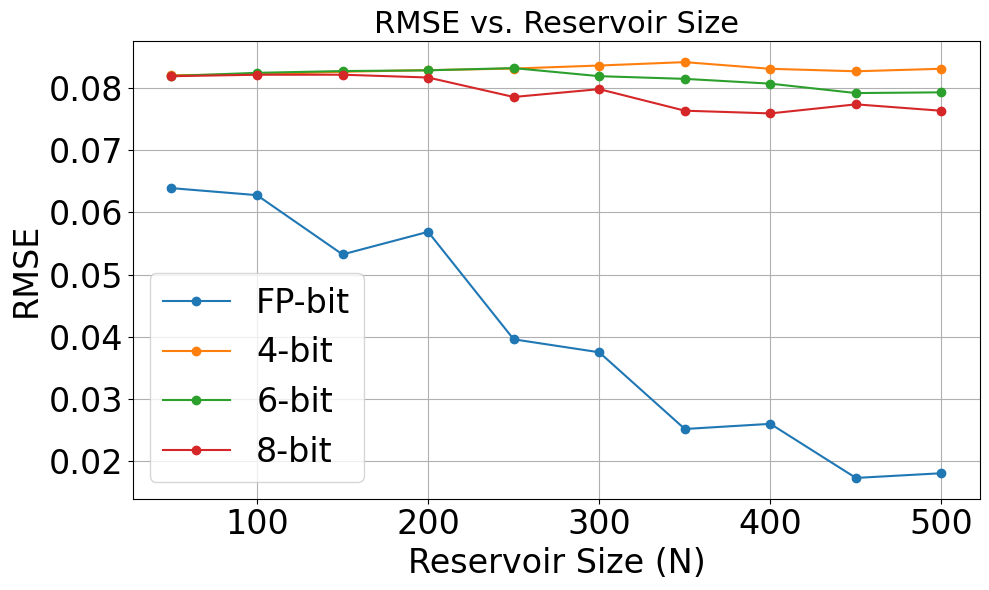

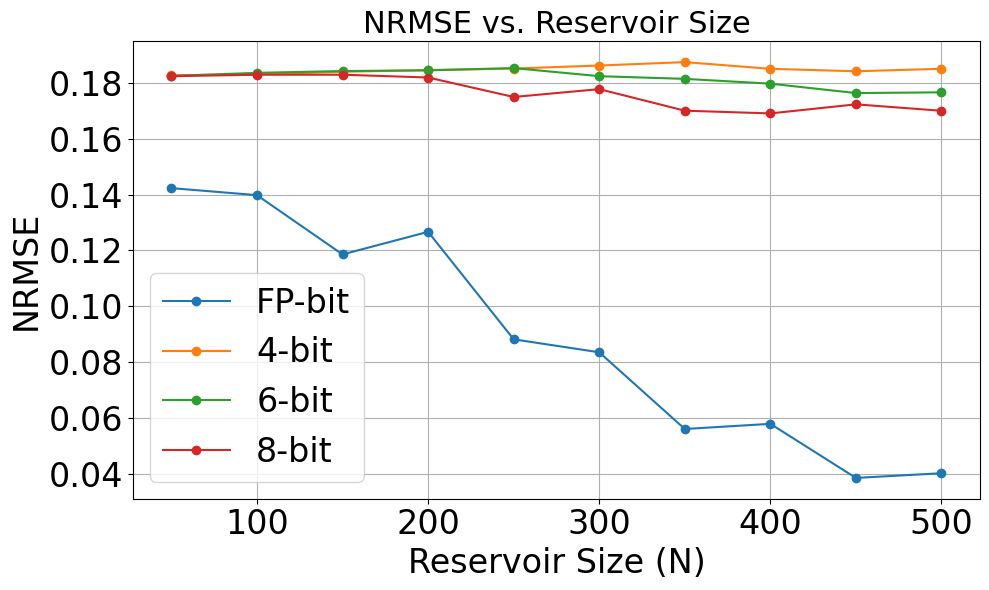

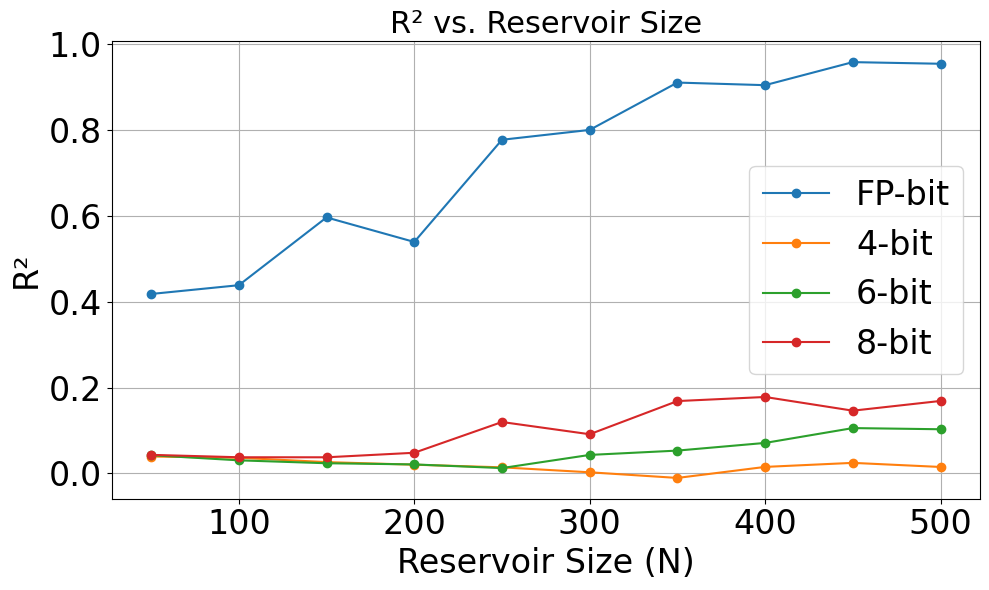

In [4]:
import matplotlib.pyplot as plt

for metric in ['RMSE', 'NRMSE', 'R\u00B2']:
    plt.figure(figsize=(10, 6))
    for bits in ['FP', 4, 6, 8]:
        subset = df_results[df_results['bits'] == bits]
        plt.plot(subset['N'], subset[metric], marker='o', label=f"{bits}-bit")

    plt.title(f"{metric} vs. Reservoir Size", fontsize=22)
    plt.xlabel("Reservoir Size (N)", fontsize=24)
    plt.ylabel(metric, fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


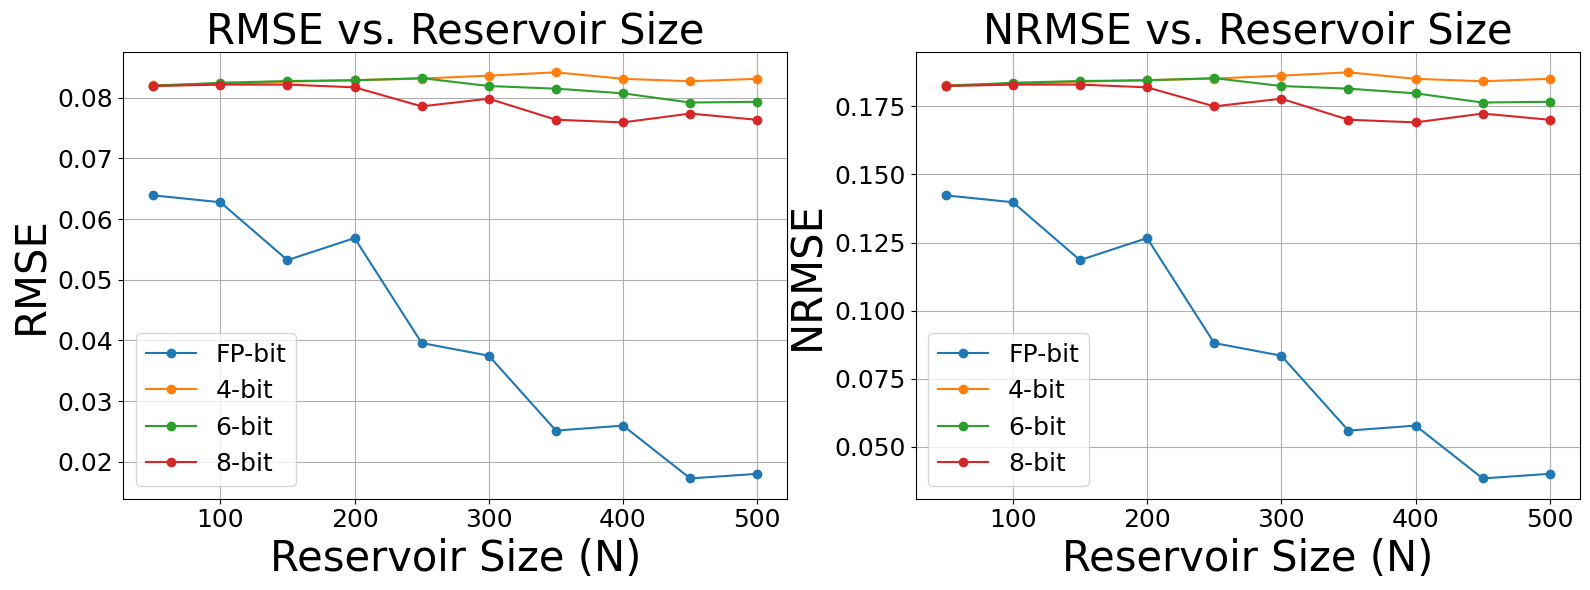

In [5]:
import matplotlib.pyplot as plt
a="R\u00B2"
metrics = ['RMSE', 'NRMSE']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

for i, metric in enumerate(metrics):
    ax = axes[i]
    for bits in ['FP', 4, 6, 8]:
        subset = df_results[df_results['bits'] == bits]
        ax.plot(subset['N'], subset[metric], marker='o', label=f"{bits}-bit")

    ax.set_title(f"{metric} vs. Reservoir Size", fontsize=30)
    ax.set_xlabel("Reservoir Size (N)", fontsize=30)
    ax.set_ylabel(metric, fontsize=30)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(True)
    ax.legend(fontsize=18)

plt.tight_layout()
plt.savefig("LORENZ_final_results.pdf", bbox_inches='tight')
plt.show()


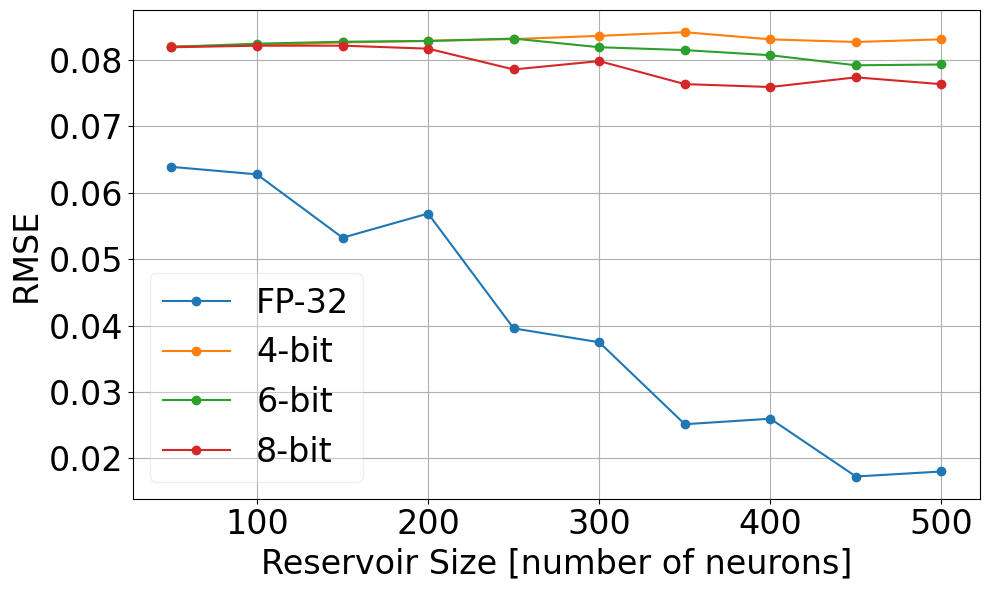

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for bits in ['FP', 4, 6, 8]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP-32' if bits == 'FP' else f"{bits}-bit"
    plt.plot(subset['N'], subset['RMSE'], marker='o', label=label)

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)
plt.tight_layout()

# Transparent legend and more space from top
plt.legend(fontsize=24, framealpha=0.3, loc='best')

plt.savefig("NARMA.pdf", bbox_inches='tight')
plt.show()

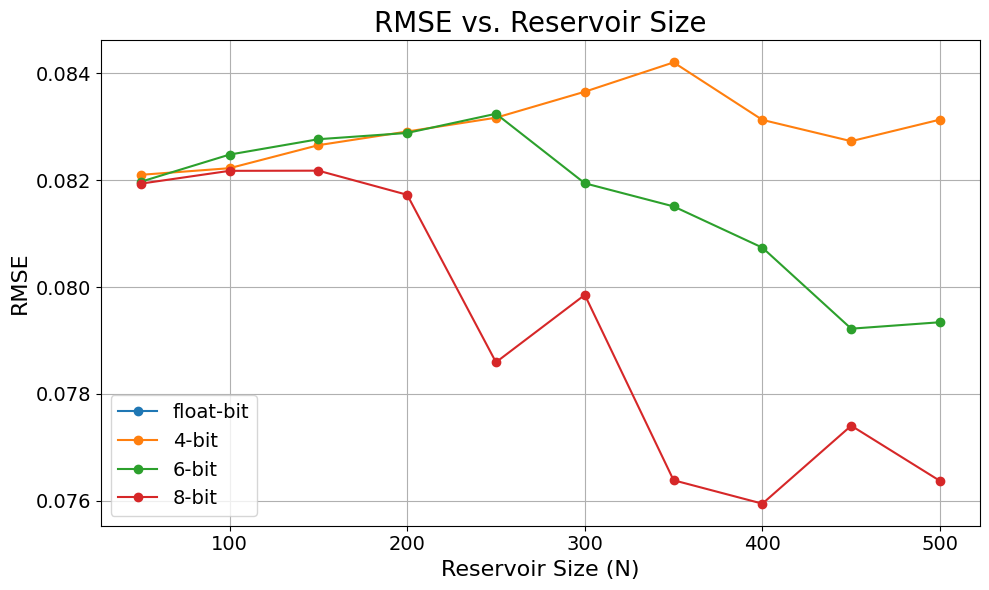

In [7]:
import matplotlib.pyplot as plt

# Assume df_results is already defined
metric = 'RMSE'

fig, ax = plt.subplots(figsize=(10, 6))

for bits in ['float', 4, 6, 8]:
    subset = df_results[df_results['bits'] == bits]
    ax.plot(subset['N'], subset[metric], marker='o', label=f"{bits}-bit")

ax.set_title(f"{metric} vs. Reservoir Size", fontsize=20)
ax.set_xlabel("Reservoir Size (N)", fontsize=16)
ax.set_ylabel(metric, fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("LORENZ_RMSE_results.pdf", bbox_inches='tight')
plt.show()


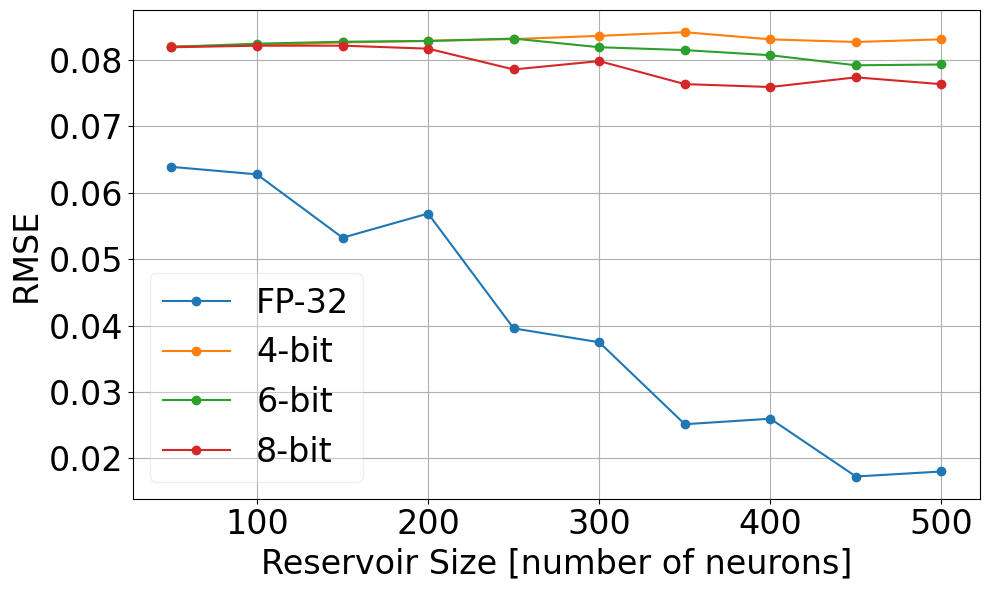

In [8]:
#last 30 August 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for bits in ['FP', 4, 6, 8]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP-32' if bits == 'FP' else f"{bits}-bit"
    plt.plot(subset['N'], subset['RMSE'], marker='o', label=label)

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)
plt.tight_layout()

# Transparent legend and more space from top
plt.legend(fontsize=24, framealpha=0.3, loc='best')

plt.savefig("narma.pdf", bbox_inches='tight')
plt.show()

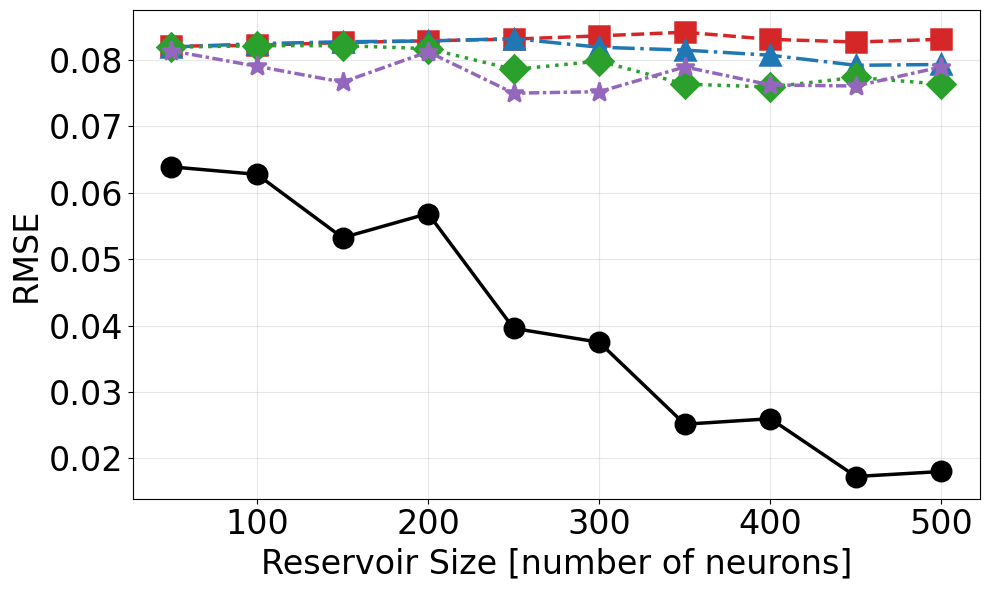

In [9]:
import matplotlib.pyplot as plt

# Define styles
styles = {
    'FP':  dict(color='black',      linestyle='-',  marker='o'),
    4:     dict(color='tab:red',    linestyle='--', marker='s'),
    6:     dict(color='tab:blue',   linestyle='-.', marker='^'),
    8:     dict(color='tab:green',  linestyle=':',  marker='D'),
    16:    dict(color='tab:purple', linestyle=(0, (3, 1, 1, 1)), marker='*')
}

plt.figure(figsize=(10, 6))

for bits in ['FP', 4, 6, 8, 16]:
    subset = df_results[df_results['bits'] == bits]
    label = 'FP-32' if bits == 'FP' else f"{bits}-bit"

    plt.plot(
        subset['N'],
        subset['RMSE'],
        label=label,
        linewidth=2.5,
        markersize=14,          # bigger markers
        markeredgewidth=1.8,    # thicker marker border

        **styles[bits]
    )

plt.xlabel("Reservoir Size [number of neurons]", fontsize=24)
plt.ylabel("RMSE", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("LORENZ_R.pdf", bbox_inches='tight')
plt.show()


In [10]:
print("R\u00B2")

R²
